<a href="https://colab.research.google.com/github/AhmedYounes94/AraBERT-Diacritic-experiment/blob/Adding-Diacritics-to-all-data/AraBERTv2_ANERCorp_Diac.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [10]:
# %cd /content/drive/My Drive/

#AraBERT for NER - on ANERCorp

ANERCorp:https://link.springer.com/chapter/10.1007/978-3-540-70939-8_13

We are using ANERCorp with Camel splits

The first part uses the Trainer API to quickly train the model


The second part defines a custom model and training loop which should be identical



**For AraBERTv1 and V2 you need to use the custom scripts** since the datasets library with the pyarrow backend dont support using farasapy

In [11]:
!pip install transformers
!pip install datasets
!pip install farasapy
!pip install pyarabic
!pip install seqeval
!git clone https://github.com/aub-mind/arabert

fatal: destination path 'arabert' already exists and is not an empty directory.


In [12]:
# !unzip "/content/drive/MyDrive/ANERcorp-CamelLabSplits.zip"

#Reading Data

In [13]:
# !head -n100 ./ANERcorp-CamelLabSplits/ANERCorp_CamelLab_train.txt

In [14]:
from collections import Counter
import matplotlib.pyplot as plt

In [15]:
def read_ANERcorp(path):
  with open(path,'r',encoding='utf-8') as f:
    data = []
    sentence = []
    label = []
    for line in f:
      if line.split()[0]=='.':
        if len(sentence) > 0:
          data.append((sentence,label))
          sentence = []
          label = []
        continue
      splits = line.split()
      sentence.append(splits[0])
      label.append(splits[1])
    if len(sentence) > 0:
      data.append((sentence,label))
  return data

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
ANERCorp_path = '/content/drive/My Drive/data/'
excel_data = pd.read_excel(ANERCorp_path+'ANERCorp_diacritized_corpus.xlsx')
np.savetxt(ANERCorp_path+'Diac_all.txt', excel_data.values, fmt='%s' )

# train, test = train_test_split(excel_data)
# np.savetxt('data/DiacTrain.txt', train.values, fmt='%s' )
# np.savetxt('data/DiacTest.txt', test.values, fmt='%s' )

In [20]:
ANERCorp_path = '/content/drive/My Drive/data/'
data_train = read_ANERcorp(ANERCorp_path+'DiacTrain.txt')
data_test = read_ANERcorp(ANERCorp_path+'DiacTest.txt')
data_all = read_ANERcorp(ANERCorp_path+'Diac_all.txt')



In [21]:
print(Counter([ label for sentence in data_test for label in sentence[1]]))
print(Counter([ label for sentence in data_train for label in sentence[1]]))

Counter({'O': 28350, 'B-LOC': 1078, 'B-PERS': 847, 'I-PERS': 627, 'B-ORG': 509, 'I-ORG': 311, 'B-MISC': 250, 'I-LOC': 141, 'I-MISC': 116})
Counter({'O': 84996, 'B-LOC': 3191, 'B-PERS': 2593, 'I-PERS': 2075, 'B-ORG': 1405, 'I-ORG': 987, 'B-MISC': 820, 'I-LOC': 445, 'I-MISC': 352})


In [22]:
label_list = list(Counter([ label for sentence in data_test for label in sentence[1]]).keys())
print(label_list)

['O', 'B-LOC', 'B-PERS', 'B-ORG', 'I-PERS', 'I-ORG', 'I-MISC', 'B-MISC', 'I-LOC']


Training Sentence Lengths: 


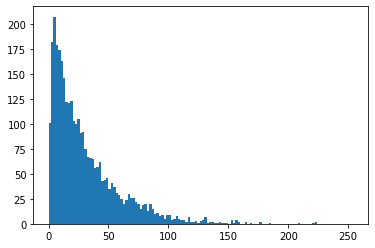

0
Testing Sentence Lengths: 


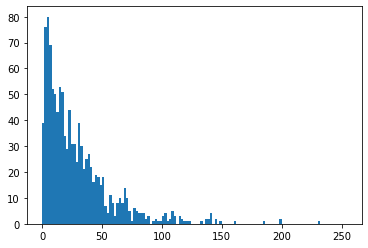

0


In [23]:
print("Training Sentence Lengths: ")
plt.hist([ len(sentence[0]) for sentence in data_train],bins=range(0,256,2))
plt.show()
print(sum([len(sentence[0]) > 512 for sentence in data_train]))

print("Testing Sentence Lengths: ")
plt.hist([ len(sentence[0]) for sentence in data_test],bins=range(0,256,2))
plt.show()
print(sum([len(sentence[0]) > 256 for sentence in data_test]))

#NER with Trainer

In [24]:
!wget https://raw.githubusercontent.com/huggingface/transformers/master/examples/token-classification/run_ner.py

--2021-02-24 13:03:13--  https://raw.githubusercontent.com/huggingface/transformers/master/examples/token-classification/run_ner.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19188 (19K) [text/plain]
Saving to: ‘run_ner.py.2’

run_ner.py.2        100%[===================>]  18.74K  --.-KB/s    in 0.001s  

2021-02-24 13:03:13 (28.0 MB/s) - ‘run_ner.py.2’ saved [19188/19188]



Converting data to huggingface supported format
1 json per line with "tokens" and "ner_tags" as keys

close to this for format https://github.com/huggingface/transformers/blob/master/tests/fixtures/tests_samples/conll/sample.json

In [25]:
import json

with open("train_data.json", "w") as outfile:
  for examples in data_train:
    ex_dict = {
        "tokens":examples[0],
        "ner_tags":examples[1]
    }
    json.dump(ex_dict, outfile)
    outfile.write('\n')

with open("test_data.json", "w") as outfile:
  for examples in data_test:
    ex_dict = {
        "tokens":examples[0],
        "ner_tags":examples[1]
    }
    json.dump(ex_dict, outfile)
    outfile.write('\n')

In [26]:
# !python run_ner.py \
#   --model_name_or_path aubmindlab/bert-large-arabertv02 \
#   --train_file train_data.json \
#   --validation_file test_data.json \
#   --output_dir ./test-ner \
#   --do_train \
#   --do_eval \
#   --per_device_train_batch_size 4 \
#   --gradient_accumulation_steps 8 \
#   --learning_rate 3e-5 \
#   --num_train_epochs 10 \
#   --warmup_steps 0 \
#   --evaluation_strategy epoch \
#   --save_steps 10000 \
#   --overwrite_output_dir \
#   --seed 42 \
#   --fp16 \

#NER with custom Model

##Model Files

In [27]:
from sklearn import preprocessing
from sklearn import model_selection

from arabert.preprocess import ArabertPreprocessor, prefix_symbols , suffix_symblos

from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import transformers
import torch

import torch.nn as nn
import numpy as np

import joblib
import pickle

from tqdm import tqdm_notebook as tqdm

from seqeval.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

In [28]:
MAX_SEQ_LEN = 128
max_diac_len = 10
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 8
EPOCHS = 5
LEARNING_RATE = 5e-5
WARMUP_RATIO = 0.1
MAX_GRAD_NORM = 1.0
accumulation_steps = 1


#You can try other Arabic BERT models by just changing the path here
#In our tests AraBERT (v1&v0.1) outperformed all tested models :)
BASE_MODEL_PATH = 'aubmindlab/bert-base-arabertv02'
MODEL_PATH = "model.bin"
TOKENIZER = transformers.BertTokenizer.from_pretrained(
    BASE_MODEL_PATH,
    do_lower_case=False)
arabert_prep = ArabertPreprocessor(BASE_MODEL_PATH.split("/")[-1])

In [29]:
tokenized_data = []
for sentence in data_test:
  tokenized_sentence = []
  for word in sentence[0]:
    tokenized_sentence.extend(TOKENIZER.tokenize(word))
  tokenized_data.append(tokenized_sentence)

#checking if Max length is compatible with the test data and doesnt cut any sentence in the test data weh
print(sum([len(sentence[0]) > MAX_SEQ_LEN for sentence in tokenized_data]))

0


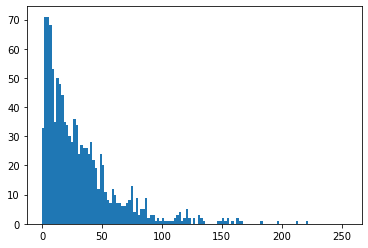

23


In [30]:
# check if the test_dataset is fully covered
tokenized_data = [TOKENIZER.tokenize(arabert_prep.preprocess(" ".join(sentence[0]))) for sentence in data_test]
plt.hist([ len(x) for x in tokenized_data],bins=range(0,256,2))
plt.show()
print(sum([len(x) > MAX_SEQ_LEN for x in tokenized_data]))

In [31]:
def get_tashkel(sentence):
    harakat   = [1614,1615,1616,1618,1617,1611,1612,1613]
    connector = 1617
    strange=[' ','«','»','í','ü','،','؛','؟','–','’','“','”','…','',]

    output = []
    current_haraka = ""
    for ch in reversed(sentence):
        if ord(ch) in harakat:
            if (current_haraka is "") or\
            (ord(ch) == connector and chr(connector) not in current_haraka) or\
            (chr(connector) == current_haraka):
                current_haraka += ch
        else:
            if current_haraka == "":
                current_haraka = "ـ"
            output.insert(0, current_haraka)
            current_haraka = ""
    return output
def clear_tashkel(text):
    text = "".join(c for c in text if ord(c) not in harakat)
    return text

In [32]:
data = data_all
texts= [s[0] for s in data]
words = set([word for sent in texts for word in sent])
diacs = set([w_i for w in words  for w_i in get_tashkel(w)])
n_diacs = len(diacs) + 2
diac2idx = {c: i + 2 for i, c in enumerate(diacs)}
diac2idx['<unk>'] = 0
diac2idx['<pad>'] = 1
idx2diac = {i :c for c, i in diac2idx.items() }


In [40]:
class NERDataset:
  def __init__(self, texts, tags, label_list, preprocessor):
    self.texts = texts
    self.tags = tags
    self.label_map = {label: i for i, label in enumerate(label_list)}
    self.preprocessor = preprocessor    
    self.pad_token_label_id = nn.CrossEntropyLoss().ignore_index
    # Use cross entropy ignore_index as padding label id so that only
    # real label ids contribute to the loss later.

     
  def __len__(self):
    return len(self.texts)
  
  def __getitem__(self, item):
    textlist = self.texts[item]
    tags = self.tags[item]

    tokens = []
    label_ids = []
    diac_input_ids = []
    for word, label in zip(textlist, tags):      
      clean_word = self.preprocessor.preprocess(word)  
      word_tokens = TOKENIZER.tokenize(clean_word)
      diac_sequence = []
      for i in range(max_diac_len):
          try:
              tashkeel=get_tashkel(word)
              diac_sequence.append(diac2idx.get(tashkeel[i]))
          except:
              diac_sequence.append(diac2idx.get('<pad>',1))

      if len(word_tokens) > 0:
        # print(word_tokens)
        # print(word)
        # print(label)
        tokens.extend(word_tokens)    
        # Use the real label id for the first token of the word, and padding ids for the remaining tokens
        label_ids.extend([self.label_map[label]] + [self.pad_token_label_id] * (len(word_tokens) - 1))
        diac_input_ids.append(diac_sequence)
 
    # Account for [CLS] and [SEP] with "- 2" and with "- 3" for RoBERTa.
    special_tokens_count = TOKENIZER.num_special_tokens_to_add()
    if len(tokens) > MAX_SEQ_LEN - special_tokens_count:
      tokens = tokens[: (MAX_SEQ_LEN - special_tokens_count)]
      label_ids = label_ids[: (MAX_SEQ_LEN - special_tokens_count)]
      diac_input_ids = diac_input_ids[:(MAX_SEQ_LEN - special_tokens_count)]
  
    #Add the [SEP] token
    tokens += [TOKENIZER.sep_token]
    label_ids += [self.pad_token_label_id]
    token_type_ids = [0] * len(tokens)
    diac_input_ids.insert(0, [1] * (max_diac_len))


    #Add the [CLS] TOKEN
    tokens = [TOKENIZER.cls_token] + tokens
    label_ids = [self.pad_token_label_id] + label_ids
    token_type_ids = [0] + token_type_ids
    diac_input_ids.insert(len(diac_input_ids), [1] * (max_diac_len))
    input_ids = TOKENIZER.convert_tokens_to_ids(tokens)
    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    attention_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    padding_length = MAX_SEQ_LEN - len(input_ids)

    input_ids += [TOKENIZER.pad_token_id] * padding_length
    attention_mask += [0] * padding_length
    token_type_ids += [0] * padding_length
    label_ids += [self.pad_token_label_id] * padding_length
    while len(diac_input_ids) != MAX_SEQ_LEN:
      diac_input_ids.insert(len(diac_input_ids), [1] * max_diac_len)


    assert len(input_ids) == MAX_SEQ_LEN
    assert len(attention_mask) == MAX_SEQ_LEN
    assert len(token_type_ids) == MAX_SEQ_LEN
    assert len(label_ids) == MAX_SEQ_LEN

    # if item < 5:
    #   print("*** Example ***")
    #   print("tokens:", " ".join([str(x) for x in tokens]))
    #   print("input_ids:", " ".join([str(x) for x in input_ids]))
    #   print("attention_mask:", " ".join([str(x) for x in attention_mask]))
    #   print("token_type_ids:", " ".join([str(x) for x in token_type_ids]))
    #   print("label_ids:", " ".join([str(x) for x in label_ids]))
    
    return {
        'input_ids' : torch.tensor(input_ids, dtype=torch.long),
        'attention_mask' : torch.tensor(attention_mask, dtype=torch.long),
        'token_type_ids' : torch.tensor(token_type_ids, dtype=torch.long),
        'labels' : torch.tensor(label_ids, dtype=torch.long),
        'diac_input_ids' : torch.tensor(diac_input_ids, dtype=torch.long)
       
    }


In [34]:
def loss_fn(output, target, mask, num_labels):
    lfn = nn.CrossEntropyLoss()
    active_loss = mask.view(-1) == 1
    active_logits = output.view(-1, num_labels)
    active_labels = torch.where(
        active_loss,
        target.view(-1),
        torch.tensor(lfn.ignore_index).type_as(target)
    )
    loss = lfn(active_logits, active_labels)
    return loss


class NERModel(nn.Module):
    def __init__(self, num_tag):
        super(NERModel, self).__init__()
        self.num_tag = num_tag
        self.bert = transformers.AutoModel.from_pretrained(BASE_MODEL_PATH)
        self.bert_drop = nn.Dropout(0.3)
        self.out_tag = nn.Linear(self.bert.config.hidden_size, self.num_tag)
        char_emb_dim = 10
        self.char_emb_dim = char_emb_dim
        self.char_emb = nn.Embedding(
            num_embeddings=23,
            embedding_dim=char_emb_dim,
            padding_idx=1
        )
        self.char_emb_dropout = nn.Dropout(0.6)

        self.char_cnn = nn.Conv1d(
            in_channels=char_emb_dim,
            out_channels= char_emb_dim,
            kernel_size=3,
            groups=char_emb_dim  # different 1d conv for each embedding dim
        )

        self.char_dropout = nn.Dropout(0.6)
        self.out_tag = nn.Linear(768 + char_emb_dim, self.num_tag)
 
 
    def forward(self, input_ids, attention_mask, token_type_ids, labels, diac_input_ids):
        output = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids,output_hidden_states=True)
        bo_tag = self.bert_drop(output['last_hidden_state'])
        # logits = self.out_tag(bo_tag)
        char_emb_out = self.char_emb_dropout(self.char_emb(diac_input_ids))
        batch_size, sent_len, word_len, char_emb_dim = char_emb_out.shape
        char_cnn_max_out = torch.zeros(batch_size, sent_len, self.char_cnn.out_channels)
        for sent_i in range(sent_len):
            sent_char_emb = char_emb_out[:, sent_i, :, :]  # get the character field of sent i
            sent_char_emb_p = sent_char_emb.permute(0, 2, 1)  # the channel (char emb dim) has to be the last dimension
            char_cnn_sent_out = self.char_cnn(sent_char_emb_p)
            char_cnn_max_out[:, sent_i, :], _ = torch.max(char_cnn_sent_out, dim=2)  # max pooling over the word length dimension
        char_cnn = self.char_dropout(char_cnn_max_out).cuda()
        word_features = torch.cat((bo_tag, char_cnn), dim=2)

        logits = self.out_tag(word_features)


        loss_tag = loss_fn(logits, labels, attention_mask, self.num_tag)
        return loss_tag, logits

In [35]:
inv_label_map = {i: label for i, label in enumerate(label_list)}

def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)

    batch_size, seq_len = preds.shape

    out_label_list = [[] for _ in range(batch_size)]
    preds_list = [[] for _ in range(batch_size)]

    for i in range(batch_size):
        for j in range(seq_len):
            if label_ids[i, j] != nn.CrossEntropyLoss().ignore_index:
                out_label_list[i].append(inv_label_map[label_ids[i][j]])
                preds_list[i].append(inv_label_map[preds[i][j]])

    return preds_list, out_label_list

def compute_metrics(predictions,label_ids):
    preds_list, out_label_list = align_predictions(predictions,label_ids)
    print(classification_report(out_label_list, preds_list,digits=4))
    return {
        "accuracy_score": accuracy_score(out_label_list, preds_list),
        "precision": precision_score(out_label_list, preds_list),
        "recall": recall_score(out_label_list, preds_list),
        "f1": f1_score(out_label_list, preds_list),
    }

In [36]:
def train_fn(data_loader, model, optimizer, device, scheduler):
    model.train()
    final_loss = 0
    for i, data in enumerate(tqdm(data_loader, total=len(data_loader))):
        for k, v in data.items():
            data[k] = v.to(device)
        outputs = model(**data)
        loss = outputs[0]
        loss.backward()
        final_loss += loss.item()
        if (i + 1 ) % accumulation_steps == 0:
          torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
          optimizer.step()
          scheduler.step()          
          optimizer.zero_grad()
    return final_loss / len(data_loader)

def eval_fn(data_loader, model, device):
    model.eval()
    with torch.no_grad():
      final_loss = 0
      preds= None
      labels = None
      for data in tqdm(data_loader, total=len(data_loader)):
        for k, v in data.items():
            data[k] = v.to(device)
        outputs = model(**data)
        loss = outputs[0]
        logits = outputs[1]
        final_loss += loss.item()
        if logits is not None:        
          preds = logits if preds is None else torch.cat((preds, logits), dim=0)
        if data['labels'] is not None:
          labels = data['labels'] if labels is None else torch.cat((labels, data['labels']), dim=0)

      preds = preds.detach().cpu().numpy()
      labels = labels.cpu().numpy()     
    
    return compute_metrics(preds,labels), final_loss

In [37]:
import torch
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
    !nvidia-smi

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Wed Feb 24 13:03:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                            

##Cross_validation Loop


In [42]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5,shuffle=False, random_state=42)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [ ]:
test_dataset = NERDataset(
    texts= [x[0] for x in data_test],
    tags = [x[1] for x in data_test],
    label_list = label_list,
    preprocessor=arabert_prep)

test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=VALID_BATCH_SIZE,
    num_workers=1
)

In [ ]:
fold_best_f1 = 0
best_fold = None
for fold_num , (train, dev) in enumerate(kf.split(data_train)):
  print("Starting Fold Num: ", fold_num)
  train_dataset = NERDataset(
    texts= [x[0] for x in [data_train[x] for x in train]],
    tags = [x[1] for x in [data_train[x] for x in train]],
    label_list = label_list,
    preprocessor=arabert_prep)

  train_dataloader = torch.utils.data.DataLoader(
      dataset=train_dataset,
      batch_size=TRAIN_BATCH_SIZE,
      num_workers=2
  )

  dev_dataset = NERDataset(
      texts= [x[0] for x in [ data_train[x] for x in dev]],
      tags = [x[1] for x in [ data_train[x] for x in dev]],
      label_list = label_list,
      preprocessor=arabert_prep)

  dev_dataloader = torch.utils.data.DataLoader(
      dataset=dev_dataset,
      batch_size=VALID_BATCH_SIZE,
      num_workers=1
  )

  num_tag = len(label_list)
  model = NERModel(num_tag=num_tag)
  model.to(device)
  print('MODEL LOADED!')

  param_optimizer = list(model.named_parameters())
  no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
  optimizer_parameters = [
      {
          "params": [
              p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
          ],
          "weight_decay": 0.01,
      },
      {
          "params": [
              p for n, p in param_optimizer if any(nd in n for nd in no_decay)
          ],
          "weight_decay": 0.0,
      },
  ]

  num_train_steps = int(len(train_dataset) / TRAIN_BATCH_SIZE * EPOCHS)
  print('Number of training steps: ', num_train_steps)
  optimizer = AdamW(optimizer_parameters, lr=LEARNING_RATE)
  scheduler = get_linear_schedule_with_warmup(
      optimizer, num_warmup_steps=int(WARMUP_RATIO*num_train_steps), num_training_steps=num_train_steps
  )
  
  for epoch in range(EPOCHS):
      train_loss = train_fn(train_dataloader, model, optimizer, device, scheduler)
      eval_metrics, eval_loss = eval_fn(dev_dataloader, model, device)
      print(f"Train Loss = {train_loss} Valid Loss = {eval_loss}")
      print(eval_metrics)
      if eval_metrics['f1'] > fold_best_f1:
        print('New Best Model Found!')
        torch.save(model.state_dict(), MODEL_PATH)
        fold_best_f1 = eval_metrics['f1']
        best_fold = fold_num

Starting Fold Num:  0
MODEL LOADED!
Number of training steps:  814


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



              precision    recall  f1-score   support

         LOC     0.8963    0.9131    0.9046      1013
        MISC     0.7273    0.5363    0.6174       179
         ORG     0.7350    0.6957    0.7148       299
        PERS     0.9363    0.9299    0.9331       585

   micro avg     0.8743    0.8540    0.8640      2076
   macro avg     0.8237    0.7688    0.7925      2076
weighted avg     0.8698    0.8540    0.8605      2076

Train Loss = 0.4130458234655071 Valid Loss = 11.095072170486674
{'accuracy_score': 0.9740559867445714, 'precision': 0.8742603550295858, 'recall': 0.8540462427745664, 'f1': 0.8640350877192982}
New Best Model Found!



              precision    recall  f1-score   support

         LOC     0.9415    0.9052    0.9230      1013
        MISC     0.7051    0.6145    0.6567       179
         ORG     0.8036    0.7525    0.7772       299
        PERS     0.9237    0.9316    0.9277       585

   micro avg     0.8985    0.8656    0.8817      2076
   macro avg     0.8435    0.8010    0.8211      2076
weighted avg     0.8962    0.8656    0.8804      2076

Train Loss = 0.07995072709813576 Valid Loss = 9.351921422523446
{'accuracy_score': 0.9793755995465248, 'precision': 0.8985, 'recall': 0.865606936416185, 'f1': 0.881746810598626}
New Best Model Found!



              precision    recall  f1-score   support

         LOC     0.9225    0.9161    0.9193      1013
        MISC     0.7097    0.7374    0.7233       179
         ORG     0.6712    0.8194    0.7380       299
        PERS     0.9265    0.9487    0.9375       585

   micro avg     0.8627    0.8960    0.8790      2076
   macro avg     0.8075    0.8554    0.8295      2076
weighted avg     0.8691    0.8960    0.8814      2076

Train Loss = 0.043899276450224956 Valid Loss = 9.800649808777962
{'accuracy_score': 0.9784599284904508, 'precision': 0.862708719851577, 'recall': 0.8959537572254336, 'f1': 0.8790170132325144}



              precision    recall  f1-score   support

         LOC     0.9257    0.9230    0.9244      1013
        MISC     0.8071    0.6313    0.7085       179
         ORG     0.8218    0.7559    0.7875       299
        PERS     0.9327    0.9470    0.9398       585

   micro avg     0.9054    0.8805    0.8928      2076
   macro avg     0.8718    0.8143    0.8400      2076
weighted avg     0.9025    0.8805    0.8904      2076

Train Loss = 0.027300259024133345 Valid Loss = 10.72697585663991
{'accuracy_score': 0.980465684137089, 'precision': 0.9053987122337791, 'recall': 0.8805394990366089, 'f1': 0.8927960927960928}
New Best Model Found!



              precision    recall  f1-score   support

         LOC     0.9220    0.9220    0.9220      1013
        MISC     0.7857    0.6760    0.7267       179
         ORG     0.8267    0.7659    0.7951       299
        PERS     0.9311    0.9470    0.9390       585

   micro avg     0.9014    0.8854    0.8933      2076
   macro avg     0.8664    0.8277    0.8457      2076
weighted avg     0.8991    0.8854    0.8917      2076

Train Loss = 0.01755553407221747 Valid Loss = 10.730819006130332
{'accuracy_score': 0.9809453213569373, 'precision': 0.9014222658165768, 'recall': 0.8853564547206165, 'f1': 0.8933171324422843}
New Best Model Found!
Starting Fold Num:  1
MODEL LOADED!
Number of training steps:  814



              precision    recall  f1-score   support

         LOC     0.8622    0.8597    0.8609       677
        MISC     0.3373    0.1718    0.2276       163
         ORG     0.6782    0.5364    0.5990       220
        PERS     0.9277    0.9096    0.9185       564

   micro avg     0.8357    0.7642    0.7983      1624
   macro avg     0.7013    0.6193    0.6515      1624
weighted avg     0.8073    0.7642    0.7819      1624

Train Loss = 0.39172994700814684 Valid Loss = 14.526649205596186
{'accuracy_score': 0.969745735436112, 'precision': 0.8356902356902357, 'recall': 0.7641625615763546, 'f1': 0.7983274364747508}



              precision    recall  f1-score   support

         LOC     0.8818    0.9040    0.8928       677
        MISC     0.4380    0.6933    0.5368       163
         ORG     0.7027    0.5909    0.6420       220
        PERS     0.9353    0.8972    0.9158       564

   micro avg     0.8111    0.8381    0.8243      1624
   macro avg     0.7395    0.7713    0.7469      1624
weighted avg     0.8316    0.8381    0.8311      1624

Train Loss = 0.07537266643763595 Valid Loss = 11.930062765604816
{'accuracy_score': 0.972550462090211, 'precision': 0.8110846245530393, 'recall': 0.8380541871921182, 'f1': 0.8243488794669898}



              precision    recall  f1-score   support

         LOC     0.8789    0.9114    0.8949       677
        MISC     0.5419    0.6748    0.6011       163
         ORG     0.5957    0.6227    0.6089       220
        PERS     0.9280    0.8918    0.9096       564

   micro avg     0.8151    0.8417    0.8282      1624
   macro avg     0.7361    0.7752    0.7536      1624
weighted avg     0.8238    0.8417    0.8317      1624

Train Loss = 0.04250100024467323 Valid Loss = 12.287988579424564
{'accuracy_score': 0.9739298358545221, 'precision': 0.8151460942158617, 'recall': 0.8417487684729064, 'f1': 0.8282338685246894}



              precision    recall  f1-score   support

         LOC     0.8847    0.8951    0.8899       677
        MISC     0.5858    0.6074    0.5964       163
         ORG     0.7368    0.5727    0.6445       220
        PERS     0.9224    0.9060    0.9141       564

   micro avg     0.8499    0.8264    0.8380      1624
   macro avg     0.7824    0.7453    0.7612      1624
weighted avg     0.8477    0.8264    0.8356      1624

Train Loss = 0.02674759943516742 Valid Loss = 13.760106218833243
{'accuracy_score': 0.9754931261207412, 'precision': 0.8499050031665611, 'recall': 0.8263546798029556, 'f1': 0.8379644083671557}



              precision    recall  f1-score   support

         LOC     0.8667    0.9025    0.8842       677
        MISC     0.5848    0.6135    0.5988       163
         ORG     0.6966    0.5636    0.6231       220
        PERS     0.9239    0.9043    0.9140       564

   micro avg     0.8375    0.8282    0.8328      1624
   macro avg     0.7680    0.7460    0.7550      1624
weighted avg     0.8352    0.8282    0.8305      1624

Train Loss = 0.016981275148684034 Valid Loss = 13.319171797134914
{'accuracy_score': 0.9751252931169249, 'precision': 0.8374844333748444, 'recall': 0.8282019704433498, 'f1': 0.8328173374613004}
Starting Fold Num:  2
MODEL LOADED!
Number of training steps:  814



              precision    recall  f1-score   support

         LOC     0.8404    0.8697    0.8548       975
        MISC     0.4934    0.4934    0.4934       227
         ORG     0.6424    0.6835    0.6623       297
        PERS     0.9098    0.8906    0.9001       521

   micro avg     0.7890    0.8054    0.7972      2020
   macro avg     0.7215    0.7343    0.7277      2020
weighted avg     0.7902    0.8054    0.7976      2020

Train Loss = 0.4409441011129347 Valid Loss = 10.864612553268671
{'accuracy_score': 0.9742184755883386, 'precision': 0.7890397672162949, 'recall': 0.8054455445544555, 'f1': 0.797158255756982}



              precision    recall  f1-score   support

         LOC     0.8684    0.8667    0.8676       975
        MISC     0.5972    0.5551    0.5753       227
         ORG     0.7984    0.6936    0.7423       297
        PERS     0.9053    0.8445    0.8739       521

   micro avg     0.8387    0.8005    0.8191      2020
   macro avg     0.7924    0.7400    0.7648      2020
weighted avg     0.8372    0.8005    0.8179      2020

Train Loss = 0.07545327408056408 Valid Loss = 10.189847680390812
{'accuracy_score': 0.9763610818405339, 'precision': 0.8386929460580913, 'recall': 0.8004950495049505, 'f1': 0.8191489361702128}



              precision    recall  f1-score   support

         LOC     0.8429    0.8697    0.8561       975
        MISC     0.5907    0.5595    0.5747       227
         ORG     0.6451    0.7710    0.7025       297
        PERS     0.9133    0.9098    0.9115       521

   micro avg     0.8010    0.8307    0.8156      2020
   macro avg     0.7480    0.7775    0.7612      2020
weighted avg     0.8036    0.8307    0.8162      2020

Train Loss = 0.04376609477520195 Valid Loss = 10.882981366477907
{'accuracy_score': 0.976325957147875, 'precision': 0.8009546539379475, 'recall': 0.8306930693069307, 'f1': 0.8155528554070474}



              precision    recall  f1-score   support

         LOC     0.8485    0.8728    0.8605       975
        MISC     0.6373    0.5727    0.6032       227
         ORG     0.7390    0.7340    0.7365       297
        PERS     0.8953    0.8868    0.8910       521

   micro avg     0.8231    0.8223    0.8227      2020
   macro avg     0.7800    0.7666    0.7728      2020
weighted avg     0.8207    0.8223    0.8212      2020

Train Loss = 0.027167491255216645 Valid Loss = 11.541781673789956
{'accuracy_score': 0.978011942395504, 'precision': 0.8230921704658077, 'recall': 0.8222772277227722, 'f1': 0.8226844972758791}



              precision    recall  f1-score   support

         LOC     0.8524    0.8769    0.8645       975
        MISC     0.6477    0.5507    0.5952       227
         ORG     0.7426    0.7576    0.7500       297
        PERS     0.9046    0.9098    0.9072       521

   micro avg     0.8300    0.8312    0.8306      2020
   macro avg     0.7868    0.7737    0.7792      2020
weighted avg     0.8267    0.8312    0.8284      2020

Train Loss = 0.01692277648481912 Valid Loss = 11.237281228270149
{'accuracy_score': 0.9783280646294344, 'precision': 0.8299555116164112, 'recall': 0.8311881188118811, 'f1': 0.8305713579025477}
Starting Fold Num:  3
MODEL LOADED!
Number of training steps:  814



              precision    recall  f1-score   support

         LOC     0.9118    0.9248    0.9182       771
        MISC     0.5846    0.6653    0.6223       239
         ORG     0.6847    0.8274    0.7493       475
        PERS     0.8834    0.9090    0.8960       692

   micro avg     0.8094    0.8700    0.8386      2177
   macro avg     0.7661    0.8316    0.7965      2177
weighted avg     0.8173    0.8700    0.8418      2177

Train Loss = 0.40593681693008526 Valid Loss = 12.132517383666709
{'accuracy_score': 0.9723093430174975, 'precision': 0.8094017094017094, 'recall': 0.8700045934772623, 'f1': 0.8386096967013504}



              precision    recall  f1-score   support

         LOC     0.8777    0.9494    0.9121       771
        MISC     0.5906    0.7364    0.6555       239
         ORG     0.7304    0.8042    0.7655       475
        PERS     0.9073    0.9191    0.9131       692

   micro avg     0.8175    0.8847    0.8498      2177
   macro avg     0.7765    0.8523    0.8116      2177
weighted avg     0.8234    0.8847    0.8523      2177

Train Loss = 0.07175652422810808 Valid Loss = 10.78945826832205
{'accuracy_score': 0.9732172334103665, 'precision': 0.8174872665534805, 'recall': 0.8847037207165824, 'f1': 0.8497683653209795}



              precision    recall  f1-score   support

         LOC     0.9191    0.9429    0.9309       771
        MISC     0.6929    0.6987    0.6958       239
         ORG     0.7826    0.7958    0.7891       475
        PERS     0.9120    0.9133    0.9126       692

   micro avg     0.8623    0.8746    0.8684      2177
   macro avg     0.8267    0.8377    0.8321      2177
weighted avg     0.8622    0.8746    0.8683      2177

Train Loss = 0.03831797308342794 Valid Loss = 9.622860134157236
{'accuracy_score': 0.9776328821393199, 'precision': 0.8623188405797102, 'recall': 0.8745980707395499, 'f1': 0.8684150513112885}



              precision    recall  f1-score   support

         LOC     0.9243    0.9507    0.9373       771
        MISC     0.7707    0.6611    0.7117       239
         ORG     0.7992    0.8042    0.8017       475
        PERS     0.9097    0.9176    0.9137       692

   micro avg     0.8776    0.8764    0.8770      2177
   macro avg     0.8510    0.8334    0.8411      2177
weighted avg     0.8755    0.8764    0.8754      2177

Train Loss = 0.022459910884342425 Valid Loss = 10.118840338778682
{'accuracy_score': 0.9793248596896665, 'precision': 0.8776448942042319, 'recall': 0.8764354616444648, 'f1': 0.8770397609744885}



              precision    recall  f1-score   support

         LOC     0.9160    0.9481    0.9318       771
        MISC     0.7523    0.6736    0.7108       239
         ORG     0.7923    0.8189    0.8054       475
        PERS     0.9113    0.9205    0.9159       692

   micro avg     0.8710    0.8810    0.8760      2177
   macro avg     0.8430    0.8403    0.8410      2177
weighted avg     0.8696    0.8810    0.8749      2177

Train Loss = 0.014849791307919344 Valid Loss = 10.38788005738752
{'accuracy_score': 0.9790359854737537, 'precision': 0.8710263396911898, 'recall': 0.8810289389067524, 'f1': 0.8759990865494406}


In [ ]:
print(fold_best_f1)
print(fold_num)

0.8933171324422843
3


In [ ]:
model.load_state_dict(torch.load(MODEL_PATH))
test_metrics, test_loss = eval_fn(test_dataloader, model, device)
print(f"Test Loss = {test_loss}")
print(test_metrics)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



              precision    recall  f1-score   support

         LOC     0.8807    0.9577    0.9176       709
        MISC     0.7413    0.6208    0.6757       240
         ORG     0.7877    0.7548    0.7709       526
        PERS     0.9052    0.8790    0.8919       934

   micro avg     0.8586    0.8493    0.8539      2409
   macro avg     0.8287    0.8031    0.8140      2409
weighted avg     0.8560    0.8493    0.8515      2409

Test Loss = 22.236330933927093
{'accuracy_score': 0.9733115690675372, 'precision': 0.858581619806966, 'recall': 0.8493150684931506, 'f1': 0.853923205342237}


##Training on all the training data


In [43]:
fold_best_f1 = 0
best_fold = None
for fold_num , (train, test) in enumerate(kf.split(data_all)):
  print("Starting Fold Num: ", fold_num)
  train_dataset = NERDataset(
    texts= [x[0] for x in [data_all[x] for x in train]],
    tags = [x[1] for x in [data_all[x] for x in train]],
    label_list = label_list,
    preprocessor=arabert_prep)

  train_dataloader = torch.utils.data.DataLoader(
      dataset=train_dataset,
      batch_size=TRAIN_BATCH_SIZE,
      num_workers=2
  )

  test_dataset = NERDataset(
      texts= [x[0] for x in [ data_all[x] for x in test]],
      tags = [x[1] for x in [ data_all[x] for x in test]],
      label_list = label_list,
      preprocessor=arabert_prep)

  test_dataloader = torch.utils.data.DataLoader(
      dataset=test_dataset,
      batch_size=VALID_BATCH_SIZE,
      num_workers=1
  )
  num_tag = len(label_list)
  model = NERModel(num_tag=num_tag)
  model.to(device)
  print('MODEL LOADED!')

  param_optimizer = list(model.named_parameters())
  no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
  optimizer_parameters = [
      {
          "params": [
              p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
          ],
          "weight_decay": 0.01,
      },
      {
          "params": [
              p for n, p in param_optimizer if any(nd in n for nd in no_decay)
          ],
          "weight_decay": 0.0,
      },
  ]

  num_train_steps = int(len(train_dataset) / TRAIN_BATCH_SIZE * EPOCHS)
  print('Number of training steps: ', num_train_steps)
  optimizer = AdamW(optimizer_parameters, lr=LEARNING_RATE)
  scheduler = get_linear_schedule_with_warmup(
      optimizer, num_warmup_steps=int(WARMUP_RATIO*num_train_steps), num_training_steps=num_train_steps
  )

  for epoch in range(EPOCHS):
      train_loss = train_fn(train_dataloader, model, optimizer, device, scheduler)
      eval_metrics, eval_loss = eval_fn(test_dataloader, model, device)
      print(f"Train Loss = {train_loss} Valid Loss = {eval_loss}")
      print(eval_metrics)
  print('New Best Model Found!')
  fold_best_f1 = eval_metrics['f1']
  print(fold_best_f1)  

# train_dataset = NERDataset(
#     texts= [x[0] for x in data_train],
#     tags = [x[1] for x in data_train],
#     label_list = label_list,
#     preprocessor=arabert_prep)

# train_dataloader = torch.utils.data.DataLoader(
#     dataset=train_dataset,
#     batch_size=TRAIN_BATCH_SIZE,
#     num_workers=2
# )

# test_dataset = NERDataset(
#     texts= [x[0] for x in data_test],
#     tags = [x[1] for x in data_test],
#     label_list = label_list,
#     preprocessor=arabert_prep)

# test_dataloader = torch.utils.data.DataLoader(
#     dataset=test_dataset,
#     batch_size=VALID_BATCH_SIZE,
#     num_workers=1
# )

Starting Fold Num:  0
MODEL LOADED!
Number of training steps:  1116


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



              precision    recall  f1-score   support

         LOC     0.9036    0.8867    0.8951      1015
        MISC     0.7615    0.5531    0.6408       179
         ORG     0.7459    0.7608    0.7533       301
        PERS     0.9297    0.9531    0.9413       597

   micro avg     0.8787    0.8590    0.8687      2092
   macro avg     0.8352    0.7884    0.8076      2092
weighted avg     0.8762    0.8590    0.8661      2092

Train Loss = 0.39238909136370886 Valid Loss = 9.900639719096944
{'accuracy_score': 0.9769303201506592, 'precision': 0.8787286063569683, 'recall': 0.8589866156787763, 'f1': 0.8687454677302394}



              precision    recall  f1-score   support

         LOC     0.9455    0.8719    0.9072      1015
        MISC     0.6832    0.6145    0.6471       179
         ORG     0.8121    0.7608    0.7856       301
        PERS     0.9291    0.9213    0.9251       597

   micro avg     0.9001    0.8480    0.8732      2092
   macro avg     0.8425    0.7921    0.8163      2092
weighted avg     0.8992    0.8480    0.8726      2092

Train Loss = 0.08003440440266527 Valid Loss = 10.304003193741664
{'accuracy_score': 0.9774439308337614, 'precision': 0.900050735667174, 'recall': 0.8479923518164436, 'f1': 0.8732463696775781}



              precision    recall  f1-score   support

         LOC     0.9370    0.8946    0.9153      1015
        MISC     0.6860    0.6592    0.6724       179
         ORG     0.7886    0.7807    0.7846       301
        PERS     0.9349    0.9380    0.9365       597

   micro avg     0.8935    0.8705    0.8818      2092
   macro avg     0.8366    0.8181    0.8272      2092
weighted avg     0.8936    0.8705    0.8818      2092

Train Loss = 0.04471323556104575 Valid Loss = 10.222331617376767
{'accuracy_score': 0.9796267762369457, 'precision': 0.8935230618253189, 'recall': 0.8704588910133844, 'f1': 0.8818401937046004}



              precision    recall  f1-score   support

         LOC     0.9355    0.8995    0.9171      1015
        MISC     0.6755    0.7095    0.6921       179
         ORG     0.7925    0.7741    0.7832       301
        PERS     0.9395    0.9363    0.9379       597

   micro avg     0.8924    0.8757    0.8840      2092
   macro avg     0.8357    0.8299    0.8326      2092
weighted avg     0.8938    0.8757    0.8845      2092

Train Loss = 0.02879496883282887 Valid Loss = 10.485481041192543
{'accuracy_score': 0.9800547851395309, 'precision': 0.8923526546517292, 'recall': 0.875717017208413, 'f1': 0.8839565741857659}



              precision    recall  f1-score   support

         LOC     0.9286    0.9222    0.9254      1015
        MISC     0.7800    0.6536    0.7112       179
         ORG     0.8309    0.7674    0.7979       301
        PERS     0.9475    0.9380    0.9428       597

   micro avg     0.9097    0.8815    0.8954      2092
   macro avg     0.8718    0.8203    0.8443      2092
weighted avg     0.9072    0.8815    0.8937      2092

Train Loss = 0.019517326718674406 Valid Loss = 10.766722026019124
{'accuracy_score': 0.9809964047252183, 'precision': 0.9097187962506167, 'recall': 0.8814531548757171, 'f1': 0.8953629521728576}
New Best Model Found!
0.8953629521728576
Starting Fold Num:  1
MODEL LOADED!
Number of training steps:  1116



              precision    recall  f1-score   support

         LOC     0.8531    0.8900    0.8712       718
        MISC     0.4596    0.3915    0.4229       189
         ORG     0.7126    0.5409    0.6150       220
        PERS     0.8811    0.9264    0.9032       584

   micro avg     0.8119    0.8025    0.8072      1711
   macro avg     0.7266    0.6872    0.7030      1711
weighted avg     0.8011    0.8025    0.7996      1711

Train Loss = 0.38317710731644183 Valid Loss = 11.73569092922844
{'accuracy_score': 0.9708691081128439, 'precision': 0.8119455943228858, 'recall': 0.8024547048509644, 'f1': 0.8071722516166961}



              precision    recall  f1-score   support

         LOC     0.9011    0.9011    0.9011       718
        MISC     0.5214    0.7090    0.6009       189
         ORG     0.6718    0.5955    0.6313       220
        PERS     0.9304    0.9161    0.9232       584

   micro avg     0.8292    0.8457    0.8374      1711
   macro avg     0.7562    0.7804    0.7641      1711
weighted avg     0.8397    0.8457    0.8408      1711

Train Loss = 0.07518677978701557 Valid Loss = 10.971795343823032
{'accuracy_score': 0.9748554406868758, 'precision': 0.8292263610315186, 'recall': 0.8457042665108124, 'f1': 0.8373842592592592}



              precision    recall  f1-score   support

         LOC     0.8994    0.8969    0.8982       718
        MISC     0.5000    0.7619    0.6038       189
         ORG     0.6538    0.6182    0.6355       220
        PERS     0.9203    0.9298    0.9250       584

   micro avg     0.8141    0.8574    0.8352      1711
   macro avg     0.7434    0.8017    0.7656      1711
weighted avg     0.8309    0.8574    0.8411      1711

Train Loss = 0.04513968059213117 Valid Loss = 12.551192377053667
{'accuracy_score': 0.9727527597687051, 'precision': 0.8140954495005549, 'recall': 0.8573933372296902, 'f1': 0.8351836037574722}



              precision    recall  f1-score   support

         LOC     0.9046    0.8983    0.9015       718
        MISC     0.5642    0.7672    0.6502       189
         ORG     0.6730    0.6455    0.6589       220
        PERS     0.9298    0.9298    0.9298       584

   micro avg     0.8357    0.8621    0.8487      1711
   macro avg     0.7679    0.8102    0.7851      1711
weighted avg     0.8458    0.8621    0.8522      1711

Train Loss = 0.028900681951459513 Valid Loss = 12.122586930112448
{'accuracy_score': 0.9758191694410373, 'precision': 0.8356940509915014, 'recall': 0.8620689655172413, 'f1': 0.8486766398158803}



              precision    recall  f1-score   support

         LOC     0.8799    0.9081    0.8938       718
        MISC     0.6311    0.6878    0.6582       189
         ORG     0.7472    0.6045    0.6683       220
        PERS     0.9127    0.9127    0.9127       584

   micro avg     0.8473    0.8463    0.8468      1711
   macro avg     0.7927    0.7783    0.7833      1711
weighted avg     0.8465    0.8463    0.8452      1711

Train Loss = 0.019454232138871572 Valid Loss = 12.178945740815834
{'accuracy_score': 0.9770019274575084, 'precision': 0.8472791105909889, 'recall': 0.8462887200467563, 'f1': 0.8467836257309943}
New Best Model Found!
0.8467836257309943
Starting Fold Num:  2
MODEL LOADED!
Number of training steps:  1116



              precision    recall  f1-score   support

         LOC     0.8625    0.8710    0.8667      1023
        MISC     0.5490    0.5209    0.5346       215
         ORG     0.6761    0.6919    0.6839       344
        PERS     0.8840    0.9112    0.8974       552

   micro avg     0.8082    0.8172    0.8127      2134
   macro avg     0.7429    0.7487    0.7457      2134
weighted avg     0.8065    0.8172    0.8117      2134

Train Loss = 0.3579140654266147 Valid Loss = 10.221772402524948
{'accuracy_score': 0.975383882060536, 'precision': 0.8081556997219648, 'recall': 0.817244611059044, 'f1': 0.8126747437092264}



              precision    recall  f1-score   support

         LOC     0.8848    0.8710    0.8778      1023
        MISC     0.4908    0.6233    0.5492       215
         ORG     0.7337    0.7529    0.7432       344
        PERS     0.9165    0.8949    0.9056       552

   micro avg     0.8186    0.8332    0.8258      2134
   macro avg     0.7565    0.7855    0.7689      2134
weighted avg     0.8290    0.8332    0.8302      2134

Train Loss = 0.0737964242497193 Valid Loss = 10.189996342756785
{'accuracy_score': 0.9763712505532668, 'precision': 0.8186003683241252, 'recall': 0.8331771321462043, 'f1': 0.8258244310264746}



              precision    recall  f1-score   support

         LOC     0.8779    0.8573    0.8675      1023
        MISC     0.4356    0.6605    0.5250       215
         ORG     0.7075    0.7384    0.7226       344
        PERS     0.9214    0.9130    0.9172       552

   micro avg     0.7965    0.8327    0.8142      2134
   macro avg     0.7356    0.7923    0.7581      2134
weighted avg     0.8171    0.8327    0.8225      2134

Train Loss = 0.047196029274346074 Valid Loss = 11.436469282431062
{'accuracy_score': 0.9751115045452998, 'precision': 0.7965038099506948, 'recall': 0.8327085285848173, 'f1': 0.8142038946162657}



              precision    recall  f1-score   support

         LOC     0.8781    0.8661    0.8720      1023
        MISC     0.4877    0.6465    0.5560       215
         ORG     0.7059    0.7674    0.7354       344
        PERS     0.9170    0.9203    0.9186       552

   micro avg     0.8087    0.8421    0.8251      2134
   macro avg     0.7472    0.8001    0.7705      2134
weighted avg     0.8211    0.8421    0.8302      2134

Train Loss = 0.026889735400410637 Valid Loss = 12.267638099263422
{'accuracy_score': 0.9761669674168397, 'precision': 0.8087308730873087, 'recall': 0.8420805998125586, 'f1': 0.8250688705234159}



              precision    recall  f1-score   support

         LOC     0.8681    0.8817    0.8749      1023
        MISC     0.6462    0.5860    0.6146       215
         ORG     0.7515    0.7471    0.7493       344
        PERS     0.9086    0.9185    0.9135       552

   micro avg     0.8397    0.8397    0.8397      2134
   macro avg     0.7936    0.7833    0.7881      2134
weighted avg     0.8374    0.8397    0.8384      2134

Train Loss = 0.018300034079012612 Valid Loss = 11.734881313706865
{'accuracy_score': 0.978890742569201, 'precision': 0.8397375820056232, 'recall': 0.8397375820056232, 'f1': 0.8397375820056232}
New Best Model Found!
0.8397375820056232
Starting Fold Num:  3
MODEL LOADED!
Number of training steps:  1117



              precision    recall  f1-score   support

         LOC     0.9081    0.8523    0.8793       765
        MISC     0.6434    0.7124    0.6762       233
         ORG     0.6893    0.8320    0.7540       512
        PERS     0.8689    0.8990    0.8837       693

   micro avg     0.8079    0.8475    0.8272      2203
   macro avg     0.7774    0.8239    0.7983      2203
weighted avg     0.8169    0.8475    0.8301      2203

Train Loss = 0.36046416257990394 Valid Loss = 10.365755637641996
{'accuracy_score': 0.9737272876084465, 'precision': 0.8078753786239723, 'recall': 0.8474807081252838, 'f1': 0.8272042534337617}



              precision    recall  f1-score   support

         LOC     0.9204    0.8915    0.9057       765
        MISC     0.6641    0.7296    0.6953       233
         ORG     0.7551    0.8613    0.8047       512
        PERS     0.8922    0.9076    0.8999       693

   micro avg     0.8408    0.8724    0.8563      2203
   macro avg     0.8079    0.8475    0.8264      2203
weighted avg     0.8460    0.8724    0.8581      2203

Train Loss = 0.08119003046470295 Valid Loss = 9.34292140614707
{'accuracy_score': 0.9752005238173187, 'precision': 0.8407699037620298, 'recall': 0.8724466636404903, 'f1': 0.8563154377366897}



              precision    recall  f1-score   support

         LOC     0.9255    0.8771    0.9007       765
        MISC     0.7390    0.7897    0.7635       233
         ORG     0.7672    0.8496    0.8063       512
        PERS     0.9100    0.9192    0.9146       693

   micro avg     0.8599    0.8747    0.8672      2203
   macro avg     0.8354    0.8589    0.8463      2203
weighted avg     0.8641    0.8747    0.8686      2203

Train Loss = 0.046547055337993824 Valid Loss = 9.411247498064768
{'accuracy_score': 0.9774103781306269, 'precision': 0.8598839803659081, 'recall': 0.8747162959600545, 'f1': 0.8672367236723674}



              precision    recall  f1-score   support

         LOC     0.9187    0.8863    0.9022       765
        MISC     0.6958    0.7854    0.7379       233
         ORG     0.7631    0.8555    0.8066       512
        PERS     0.9073    0.9177    0.9125       693

   micro avg     0.8502    0.8783    0.8640      2203
   macro avg     0.8212    0.8612    0.8398      2203
weighted avg     0.8554    0.8783    0.8658      2203

Train Loss = 0.02599828413310336 Valid Loss = 10.067114613077138
{'accuracy_score': 0.9770829923064331, 'precision': 0.8501757469244289, 'recall': 0.8783477076713573, 'f1': 0.8640321500334897}



              precision    recall  f1-score   support

         LOC     0.9138    0.9425    0.9279       765
        MISC     0.7867    0.7597    0.7729       233
         ORG     0.8253    0.8398    0.8325       512
        PERS     0.9087    0.9192    0.9139       693

   micro avg     0.8788    0.8920    0.8853      2203
   macro avg     0.8586    0.8653    0.8618      2203
weighted avg     0.8782    0.8920    0.8850      2203

Train Loss = 0.01790892726954293 Valid Loss = 9.886503068533784
{'accuracy_score': 0.980847929284662, 'precision': 0.8788014311270125, 'recall': 0.8919655015887427, 'f1': 0.8853345348051362}
New Best Model Found!
0.8853345348051362
Starting Fold Num:  4
MODEL LOADED!
Number of training steps:  1117



              precision    recall  f1-score   support

         LOC     0.8813    0.9294    0.9047       623
        MISC     0.6842    0.5043    0.5806       232
         ORG     0.7171    0.6613    0.6881       437
        PERS     0.9074    0.8812    0.8941       867

   micro avg     0.8437    0.8101    0.8266      2159
   macro avg     0.7975    0.7441    0.7669      2159
weighted avg     0.8374    0.8101    0.8218      2159

Train Loss = 0.4052485604728905 Valid Loss = 17.28277503186837
{'accuracy_score': 0.9657421013960323, 'precision': 0.8437047756874095, 'recall': 0.8100972672533581, 'f1': 0.8265595463137996}



              precision    recall  f1-score   support

         LOC     0.8955    0.9358    0.9152       623
        MISC     0.6132    0.6422    0.6274       232
         ORG     0.7775    0.7117    0.7431       437
        PERS     0.9091    0.8651    0.8865       867

   micro avg     0.8462    0.8305    0.8382      2159
   macro avg     0.7988    0.7887    0.7931      2159
weighted avg     0.8467    0.8305    0.8379      2159

Train Loss = 0.07148773301949925 Valid Loss = 15.69512434490025
{'accuracy_score': 0.9712986774430565, 'precision': 0.8461538461538461, 'recall': 0.8304770727188513, 'f1': 0.8382421692379617}



              precision    recall  f1-score   support

         LOC     0.8918    0.9390    0.9148       623
        MISC     0.7273    0.6207    0.6698       232
         ORG     0.7196    0.7460    0.7326       437
        PERS     0.9134    0.8397    0.8750       867

   micro avg     0.8474    0.8258    0.8365      2159
   macro avg     0.8130    0.7863    0.7980      2159
weighted avg     0.8480    0.8258    0.8356      2159

Train Loss = 0.04053701403816896 Valid Loss = 18.497940229717642
{'accuracy_score': 0.9703343130051433, 'precision': 0.8474334600760456, 'recall': 0.825845298749421, 'f1': 0.8365001172882945}



              precision    recall  f1-score   support

         LOC     0.8846    0.9470    0.9147       623
        MISC     0.7487    0.6293    0.6838       232
         ORG     0.7470    0.7231    0.7349       437
        PERS     0.9141    0.8593    0.8859       867

   micro avg     0.8557    0.8323    0.8439      2159
   macro avg     0.8236    0.7897    0.8048      2159
weighted avg     0.8540    0.8323    0.8419      2159

Train Loss = 0.02354194023765948 Valid Loss = 20.374539690470556
{'accuracy_score': 0.9709313005143277, 'precision': 0.8557142857142858, 'recall': 0.8323297823066235, 'f1': 0.8438600610471942}



              precision    recall  f1-score   support

         LOC     0.8708    0.9518    0.9095       623
        MISC     0.7708    0.6379    0.6981       232
         ORG     0.7687    0.7071    0.7366       437
        PERS     0.9071    0.8789    0.8928       867

   micro avg     0.8567    0.8393    0.8479      2159
   macro avg     0.8294    0.7939    0.8093      2159
weighted avg     0.8540    0.8393    0.8451      2159

Train Loss = 0.015880514033077425 Valid Loss = 20.262865841010353
{'accuracy_score': 0.9714364437913299, 'precision': 0.8567375886524823, 'recall': 0.8392774432607689, 'f1': 0.8479176415535797}
New Best Model Found!
0.8479176415535797


In [ ]:
[0.895, 0.8467, 0.8397, 0.885, 0.8479 ]

4 Folds

In [41]:
fold_best_f1 = 0
best_fold = None
for fold_num , (train, test) in enumerate(kf.split(data_all)):
  print("Starting Fold Num: ", fold_num)
  train_dataset = NERDataset(
    texts= [x[0] for x in [data_all[x] for x in train]],
    tags = [x[1] for x in [data_all[x] for x in train]],
    label_list = label_list,
    preprocessor=arabert_prep)

  train_dataloader = torch.utils.data.DataLoader(
      dataset=train_dataset,
      batch_size=TRAIN_BATCH_SIZE,
      num_workers=2
  )

  test_dataset = NERDataset(
      texts= [x[0] for x in [ data_all[x] for x in test]],
      tags = [x[1] for x in [ data_all[x] for x in test]],
      label_list = label_list,
      preprocessor=arabert_prep)

  test_dataloader = torch.utils.data.DataLoader(
      dataset=test_dataset,
      batch_size=VALID_BATCH_SIZE,
      num_workers=1
  )
  num_tag = len(label_list)
  model = NERModel(num_tag=num_tag)
  model.to(device)
  print('MODEL LOADED!')

  param_optimizer = list(model.named_parameters())
  no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
  optimizer_parameters = [
      {
          "params": [
              p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
          ],
          "weight_decay": 0.01,
      },
      {
          "params": [
              p for n, p in param_optimizer if any(nd in n for nd in no_decay)
          ],
          "weight_decay": 0.0,
      },
  ]

  num_train_steps = int(len(train_dataset) / TRAIN_BATCH_SIZE * EPOCHS)
  print('Number of training steps: ', num_train_steps)
  optimizer = AdamW(optimizer_parameters, lr=LEARNING_RATE)
  scheduler = get_linear_schedule_with_warmup(
      optimizer, num_warmup_steps=int(WARMUP_RATIO*num_train_steps), num_training_steps=num_train_steps
  )

  for epoch in range(EPOCHS):
      train_loss = train_fn(train_dataloader, model, optimizer, device, scheduler)
      eval_metrics, eval_loss = eval_fn(test_dataloader, model, device)
      print(f"Train Loss = {train_loss} Valid Loss = {eval_loss}")
      print(eval_metrics)
  print('New Best Model Found!')
  fold_best_f1 = eval_metrics['f1']
  print(fold_best_f1)  

# train_dataset = NERDataset(
#     texts= [x[0] for x in data_train],
#     tags = [x[1] for x in data_train],
#     label_list = label_list,
#     preprocessor=arabert_prep)

# train_dataloader = torch.utils.data.DataLoader(
#     dataset=train_dataset,
#     batch_size=TRAIN_BATCH_SIZE,
#     num_workers=2
# )

# test_dataset = NERDataset(
#     texts= [x[0] for x in data_test],
#     tags = [x[1] for x in data_test],
#     label_list = label_list,
#     preprocessor=arabert_prep)

# test_dataloader = torch.utils.data.DataLoader(
#     dataset=test_dataset,
#     batch_size=VALID_BATCH_SIZE,
#     num_workers=1
# )

Starting Fold Num:  0
MODEL LOADED!
Number of training steps:  1047


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



              precision    recall  f1-score   support

         LOC     0.8826    0.8581    0.8701      1226
        MISC     0.5885    0.5381    0.5622       210
         ORG     0.6741    0.6667    0.6704       363
        PERS     0.9294    0.9422    0.9358       727

   micro avg     0.8435    0.8282    0.8358      2526
   macro avg     0.7687    0.7513    0.7596      2526
weighted avg     0.8416    0.8282    0.8347      2526

Train Loss = 0.3694751231088525 Valid Loss = 15.302234373404644
{'accuracy_score': 0.9706507868991918, 'precision': 0.8435483870967742, 'recall': 0.8281868566904196, 'f1': 0.8357970435477426}



              precision    recall  f1-score   support

         LOC     0.8958    0.9119    0.9038      1226
        MISC     0.5960    0.7095    0.6478       210
         ORG     0.7801    0.7135    0.7453       363
        PERS     0.9514    0.9422    0.9468       727

   micro avg     0.8671    0.8753    0.8712      2526
   macro avg     0.8058    0.8193    0.8109      2526
weighted avg     0.8703    0.8753    0.8721      2526

Train Loss = 0.08184882347649407 Valid Loss = 13.879805920878425
{'accuracy_score': 0.9760385651495818, 'precision': 0.8670588235294118, 'recall': 0.8752969121140143, 'f1': 0.8711583924349883}



              precision    recall  f1-score   support

         LOC     0.8998    0.8719    0.8857      1226
        MISC     0.5539    0.7095    0.6221       210
         ORG     0.7754    0.7135    0.7432       363
        PERS     0.9438    0.9464    0.9451       727

   micro avg     0.8591    0.8571    0.8581      2526
   macro avg     0.7932    0.8103    0.7990      2526
weighted avg     0.8658    0.8571    0.8604      2526

Train Loss = 0.04793195340981973 Valid Loss = 15.53381271501712
{'accuracy_score': 0.9751878633205728, 'precision': 0.8591269841269841, 'recall': 0.8570863024544735, 'f1': 0.858105430043599}



              precision    recall  f1-score   support

         LOC     0.9079    0.8760    0.8917      1226
        MISC     0.6307    0.7238    0.6741       210
         ORG     0.7794    0.7300    0.7539       363
        PERS     0.9361    0.9477    0.9419       727

   micro avg     0.8720    0.8630    0.8675      2526
   macro avg     0.8135    0.8194    0.8154      2526
weighted avg     0.8745    0.8630    0.8682      2526

Train Loss = 0.02938707871307131 Valid Loss = 15.156724661203043
{'accuracy_score': 0.9767120374308805, 'precision': 0.872, 'recall': 0.8630245447347585, 'f1': 0.8674890569040987}



              precision    recall  f1-score   support

         LOC     0.9018    0.9062    0.9040      1226
        MISC     0.7400    0.7048    0.7220       210
         ORG     0.8037    0.7218    0.7605       363
        PERS     0.9529    0.9464    0.9496       727

   micro avg     0.8907    0.8745    0.8825      2526
   macro avg     0.8496    0.8198    0.8340      2526
weighted avg     0.8890    0.8745    0.8814      2526

Train Loss = 0.020547666865362166 Valid Loss = 15.966397366923047
{'accuracy_score': 0.9779171983553098, 'precision': 0.8907258064516129, 'recall': 0.8745051464766429, 'f1': 0.8825409508589693}
New Best Model Found!
0.8825409508589693
Starting Fold Num:  1
MODEL LOADED!
Number of training steps:  1047



              precision    recall  f1-score   support

         LOC     0.8699    0.8610    0.8654      1079
        MISC     0.4656    0.4656    0.4656       262
         ORG     0.6423    0.6090    0.6252       289
        PERS     0.8916    0.8668    0.8790       683

   micro avg     0.8020    0.7864    0.7941      2313
   macro avg     0.7174    0.7006    0.7088      2313
weighted avg     0.8021    0.7864    0.7941      2313

Train Loss = 0.41153589215661796 Valid Loss = 12.95782114402391
{'accuracy_score': 0.9755359466033147, 'precision': 0.8020282186948854, 'recall': 0.7864245568525724, 'f1': 0.7941497489631084}



              precision    recall  f1-score   support

         LOC     0.9097    0.8962    0.9029      1079
        MISC     0.4677    0.5802    0.5179       262
         ORG     0.7468    0.6125    0.6730       289
        PERS     0.9174    0.8785    0.8975       683

   micro avg     0.8319    0.8197    0.8258      2313
   macro avg     0.7604    0.7418    0.7478      2313
weighted avg     0.8416    0.8197    0.8290      2313

Train Loss = 0.07974786631585587 Valid Loss = 12.239541502436623
{'accuracy_score': 0.9776288251597941, 'precision': 0.8319438350153576, 'recall': 0.8197146562905318, 'f1': 0.8257839721254355}



              precision    recall  f1-score   support

         LOC     0.9026    0.9194    0.9109      1079
        MISC     0.4985    0.6412    0.5609       262
         ORG     0.7294    0.6436    0.6838       289
        PERS     0.9202    0.9122    0.9162       683

   micro avg     0.8315    0.8513    0.8413      2313
   macro avg     0.7627    0.7791    0.7680      2313
weighted avg     0.8404    0.8513    0.8445      2313

Train Loss = 0.048881460972396394 Valid Loss = 12.40377381525468
{'accuracy_score': 0.9785904180100684, 'precision': 0.8315033783783784, 'recall': 0.8512753999135322, 'f1': 0.8412732322153386}



              precision    recall  f1-score   support

         LOC     0.8887    0.8804    0.8845      1079
        MISC     0.5192    0.7214    0.6038       262
         ORG     0.6886    0.6505    0.6690       289
        PERS     0.9217    0.8960    0.9087       683

   micro avg     0.8181    0.8383    0.8281      2313
   macro avg     0.7546    0.7871    0.7665      2313
weighted avg     0.8316    0.8383    0.8329      2313

Train Loss = 0.03236049085112643 Valid Loss = 12.681052734027617
{'accuracy_score': 0.9783358787261723, 'precision': 0.8181434599156118, 'recall': 0.8383052313013403, 'f1': 0.828101644245142}



              precision    recall  f1-score   support

         LOC     0.8863    0.9027    0.8944      1079
        MISC     0.6347    0.6565    0.6454       262
         ORG     0.7449    0.6367    0.6866       289
        PERS     0.9025    0.8946    0.8985       683

   micro avg     0.8461    0.8392    0.8426      2313
   macro avg     0.7921    0.7726    0.7812      2313
weighted avg     0.8449    0.8392    0.8414      2313

Train Loss = 0.02127387994052177 Valid Loss = 12.666030246036826
{'accuracy_score': 0.9808247072798235, 'precision': 0.8461203138622494, 'recall': 0.8391699092088197, 'f1': 0.842630779248969}
New Best Model Found!
0.842630779248969
Starting Fold Num:  2
MODEL LOADED!
Number of training steps:  1047



              precision    recall  f1-score   support

         LOC     0.9250    0.9022    0.9135      1053
        MISC     0.6436    0.6277    0.6355       282
         ORG     0.6543    0.7873    0.7146       536
        PERS     0.9121    0.9261    0.9190       852

   micro avg     0.8314    0.8586    0.8448      2723
   macro avg     0.7838    0.8108    0.7957      2723
weighted avg     0.8386    0.8586    0.8473      2723

Train Loss = 0.4231786213992607 Valid Loss = 13.322667131200433
{'accuracy_score': 0.9730048486436902, 'precision': 0.8314366998577525, 'recall': 0.8586118251928021, 'f1': 0.8448057813911473}



              precision    recall  f1-score   support

         LOC     0.9251    0.9155    0.9203      1053
        MISC     0.6799    0.6702    0.6750       282
         ORG     0.7185    0.8097    0.7614       536
        PERS     0.9223    0.9190    0.9206       852

   micro avg     0.8547    0.8704    0.8624      2723
   macro avg     0.8115    0.8286    0.8193      2723
weighted avg     0.8582    0.8704    0.8637      2723

Train Loss = 0.07931719931685144 Valid Loss = 12.317013872554526
{'accuracy_score': 0.9751343205346612, 'precision': 0.8546700324558241, 'recall': 0.8703635695923614, 'f1': 0.8624454148471616}



              precision    recall  f1-score   support

         LOC     0.9264    0.9088    0.9175      1053
        MISC     0.6699    0.7411    0.7037       282
         ORG     0.7145    0.8078    0.7583       536
        PERS     0.9147    0.9190    0.9169       852

   micro avg     0.8486    0.8748    0.8615      2723
   macro avg     0.8064    0.8442    0.8241      2723
weighted avg     0.8545    0.8748    0.8638      2723

Train Loss = 0.04575570849757198 Valid Loss = 12.96156636509113
{'accuracy_score': 0.9738893985060936, 'precision': 0.8485928037050231, 'recall': 0.8747704737421961, 'f1': 0.8614828209764918}



              precision    recall  f1-score   support

         LOC     0.9273    0.8841    0.9052      1053
        MISC     0.7043    0.7518    0.7273       282
         ORG     0.6853    0.8246    0.7485       536
        PERS     0.9176    0.9143    0.9159       852

   micro avg     0.8446    0.8682    0.8562      2723
   macro avg     0.8086    0.8437    0.8242      2723
weighted avg     0.8535    0.8682    0.8593      2723

Train Loss = 0.029033452690124424 Valid Loss = 14.219446043251082
{'accuracy_score': 0.9738238762940636, 'precision': 0.8445873526259379, 'recall': 0.868160117517444, 'f1': 0.8562115175660993}



              precision    recall  f1-score   support

         LOC     0.9212    0.9326    0.9269      1053
        MISC     0.7672    0.7128    0.7390       282
         ORG     0.7491    0.8078    0.7774       536
        PERS     0.9160    0.9214    0.9187       852

   micro avg     0.8690    0.8817    0.8753      2723
   macro avg     0.8384    0.8436    0.8405      2723
weighted avg     0.8697    0.8817    0.8754      2723

Train Loss = 0.019259272313710035 Valid Loss = 13.548720764432801
{'accuracy_score': 0.9776569256978116, 'precision': 0.8689829895041622, 'recall': 0.8817480719794345, 'f1': 0.8753189938024062}
New Best Model Found!
0.8753189938024062
Starting Fold Num:  3
MODEL LOADED!
Number of training steps:  1047



              precision    recall  f1-score   support

         LOC     0.8643    0.9402    0.9007       786
        MISC     0.5934    0.4864    0.5346       294
         ORG     0.8019    0.6917    0.7427       626
        PERS     0.8850    0.8885    0.8867      1031

   micro avg     0.8353    0.8151    0.8251      2737
   macro avg     0.7861    0.7517    0.7662      2737
weighted avg     0.8287    0.8151    0.8200      2737

Train Loss = 0.36012671192487083 Valid Loss = 20.412772642448545
{'accuracy_score': 0.9670170875329649, 'precision': 0.8352676900037439, 'recall': 0.8151260504201681, 'f1': 0.8250739644970414}



              precision    recall  f1-score   support

         LOC     0.8663    0.9478    0.9052       786
        MISC     0.7468    0.5918    0.6603       294
         ORG     0.7444    0.8003    0.7714       626
        PERS     0.9068    0.8778    0.8921      1031

   micro avg     0.8412    0.8495    0.8453      2737
   macro avg     0.8161    0.8044    0.8072      2737
weighted avg     0.8408    0.8495    0.8433      2737

Train Loss = 0.07021021276734592 Valid Loss = 19.694147607893683
{'accuracy_score': 0.9725082186337198, 'precision': 0.8411722141823444, 'recall': 0.8494702228717574, 'f1': 0.845300854390111}



              precision    recall  f1-score   support

         LOC     0.8833    0.9440    0.9127       786
        MISC     0.7725    0.6122    0.6831       294
         ORG     0.7508    0.7700    0.7603       626
        PERS     0.9013    0.8855    0.8933      1031

   micro avg     0.8493    0.8465    0.8479      2737
   macro avg     0.8270    0.8029    0.8123      2737
weighted avg     0.8479    0.8465    0.8459      2737

Train Loss = 0.03851192776180271 Valid Loss = 20.593373555282596
{'accuracy_score': 0.9731946100213142, 'precision': 0.8493401759530792, 'recall': 0.8465473145780051, 'f1': 0.8479414455626715}



              precision    recall  f1-score   support

         LOC     0.8741    0.9453    0.9083       786
        MISC     0.7563    0.6122    0.6767       294
         ORG     0.8273    0.7348    0.7783       626
        PERS     0.8991    0.8904    0.8947      1031

   micro avg     0.8634    0.8407    0.8519      2737
   macro avg     0.8392    0.7957    0.8145      2737
weighted avg     0.8602    0.8407    0.8486      2737

Train Loss = 0.0228555728969652 Valid Loss = 22.428884543129243
{'accuracy_score': 0.9729417289837795, 'precision': 0.8634146341463415, 'recall': 0.8407014979905005, 'f1': 0.8519067012217698}



              precision    recall  f1-score   support

         LOC     0.8763    0.9466    0.9101       786
        MISC     0.7689    0.5884    0.6667       294
         ORG     0.7796    0.7684    0.7739       626
        PERS     0.8946    0.8894    0.8920      1031

   micro avg     0.8524    0.8458    0.8491      2737
   macro avg     0.8299    0.7982    0.8107      2737
weighted avg     0.8496    0.8458    0.8460      2737

Train Loss = 0.014425117284658232 Valid Loss = 22.61238525173394
{'accuracy_score': 0.9733752393338391, 'precision': 0.8523564064801178, 'recall': 0.845816587504567, 'f1': 0.8490739042728773}
New Best Model Found!
0.8490739042728773


In [ ]:
[0.88, 0.84, 0.875, 0.849]

In [ ]:
num_tag = len(label_list)
model = NERModel(num_tag=num_tag)
model.to(device)
print('MODEL LOADED!')

param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
    {
        "params": [
            p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.01,
    },
    {
        "params": [
            p for n, p in param_optimizer if any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0,
    },
]

num_train_steps = int(len(train_dataset) / TRAIN_BATCH_SIZE * EPOCHS)
print('Number of training steps: ', num_train_steps)
optimizer = AdamW(optimizer_parameters, lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=int(WARMUP_RATIO*num_train_steps), num_training_steps=num_train_steps
)

for epoch in range(EPOCHS):
    train_loss = train_fn(train_dataloader, model, optimizer, device, scheduler)
    eval_metrics, eval_loss = eval_fn(test_dataloader, model, device)
    print(f"Train Loss = {train_loss} Valid Loss = {eval_loss}")
    print(eval_metrics)

MODEL LOADED!
Number of training steps:  1086


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



              precision    recall  f1-score   support

         LOC     0.8724    0.9351    0.9027       709
        MISC     0.7219    0.4542    0.5575       240
         ORG     0.7042    0.7015    0.7029       526
        PERS     0.9131    0.8437    0.8770       934

   micro avg     0.8394    0.8007    0.8196      2409
   macro avg     0.8029    0.7336    0.7600      2409
weighted avg     0.8364    0.8007    0.8147      2409

Train Loss = 0.3882173687334967 Valid Loss = 19.167685968335718
{'accuracy_score': 0.9651091613956335, 'precision': 0.839425587467363, 'recall': 0.800747198007472, 'f1': 0.8196303377947738}



              precision    recall  f1-score   support

         LOC     0.8706    0.9492    0.9082       709
        MISC     0.6724    0.6500    0.6610       240
         ORG     0.8021    0.7167    0.7570       526
        PERS     0.9067    0.8640    0.8849       934

   micro avg     0.8512    0.8356    0.8433      2409
   macro avg     0.8130    0.7950    0.8028      2409
weighted avg     0.8499    0.8356    0.8415      2409

Train Loss = 0.06860577975562134 Valid Loss = 16.861369787948206
{'accuracy_score': 0.9720465211181392, 'precision': 0.8511627906976744, 'recall': 0.8356164383561644, 'f1': 0.8433179723502303}



              precision    recall  f1-score   support

         LOC     0.8796    0.9478    0.9124       709
        MISC     0.7324    0.6500    0.6887       240
         ORG     0.7463    0.7719    0.7589       526
        PERS     0.9016    0.8630    0.8818       934

   micro avg     0.8447    0.8468    0.8458      2409
   macro avg     0.8150    0.8082    0.8105      2409
weighted avg     0.8443    0.8468    0.8448      2409

Train Loss = 0.038980021849573686 Valid Loss = 19.247209532768466
{'accuracy_score': 0.9718016731279331, 'precision': 0.84472049689441, 'recall': 0.8468244084682441, 'f1': 0.845771144278607}



              precision    recall  f1-score   support

         LOC     0.8745    0.9535    0.9123       709
        MISC     0.7744    0.6292    0.6943       240
         ORG     0.8038    0.7243    0.7620       526
        PERS     0.9087    0.8737    0.8908       934

   micro avg     0.8650    0.8402    0.8524      2409
   macro avg     0.8403    0.7952    0.8148      2409
weighted avg     0.8623    0.8402    0.8494      2409

Train Loss = 0.021959537724588373 Valid Loss = 21.052647660282673
{'accuracy_score': 0.9725362170985513, 'precision': 0.864957264957265, 'recall': 0.8401826484018264, 'f1': 0.852389976837229}



              precision    recall  f1-score   support

         LOC     0.8713    0.9549    0.9112       709
        MISC     0.7772    0.6542    0.7104       240
         ORG     0.7992    0.7490    0.7733       526
        PERS     0.9070    0.8876    0.8972       934

   micro avg     0.8621    0.8539    0.8580      2409
   macro avg     0.8387    0.8114    0.8230      2409
weighted avg     0.8600    0.8539    0.8556      2409

Train Loss = 0.0144631483346713 Valid Loss = 21.454033940535737
{'accuracy_score': 0.9741277290348909, 'precision': 0.8621123218776194, 'recall': 0.8538812785388128, 'f1': 0.8579770594369135}


In [ ]:
test_metrics, test_loss = eval_fn(test_dataloader, model, device)
print(f"Test Loss = {test_loss}")
print(test_metrics)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



              precision    recall  f1-score   support

         LOC     0.8713    0.9549    0.9112       709
        MISC     0.7772    0.6542    0.7104       240
         ORG     0.7992    0.7490    0.7733       526
        PERS     0.9070    0.8876    0.8972       934

   micro avg     0.8621    0.8539    0.8580      2409
   macro avg     0.8387    0.8114    0.8230      2409
weighted avg     0.8600    0.8539    0.8556      2409

Test Loss = 21.454033940535737
{'accuracy_score': 0.9741277290348909, 'precision': 0.8621123218776194, 'recall': 0.8538812785388128, 'f1': 0.8579770594369135}


#Results and hyper parameters

AraBERTv1

                  precision    recall  f1-score   support

             LOC     0.8919    0.9275    0.9094       676
            MISC     0.7389    0.6173    0.6726       243
             ORG     0.7748    0.6972    0.7339       459
            PERS     0.8499    0.8320    0.8409       905

       micro avg     0.8390    0.8103    0.8244      2283
       macro avg     0.8139    0.7685    0.7892      2283
    weighted avg     0.8354    0.8103    0.8217      2283

    Train Loss = 0.02561288744304329
    Valid Loss = 18.984092206461355
    'accuracy_score': 0.9703493257572726
    'precision': 0.8390022675736961
    'recall': 0.8103372755146737
    'f1': 0.8244206773618539

    MAX_SEQ_LEN = 256
    TRAIN_BATCH_SIZE = 32
    VALID_BATCH_SIZE = 8
    EPOCHS = 5
    LEARNING_RATE = 7e-5
    WARMUP_RATIO = 0.1
    MAX_GRAD_NORM = 1.0

AraBERTv0.2

                precision    recall  f1-score   support

           LOC     0.8886    0.9320    0.9097       676
          MISC     0.7590    0.6091    0.6758       243
           ORG     0.7935    0.7451    0.7685       459
          PERS     0.8832    0.8442    0.8633       905

      micro avg     0.8564    0.8252    0.8405      2283
      macro avg     0.8311    0.7826    0.8043      2283
      weighted avg     0.8536    0.8252    0.8380      2283

      Train Loss = 0.018847705767024308
      Valid Loss = 18.27915945305722
      'accuracy_score': 0.9722211071414235
      'precision': 0.8563636363636363
      'recall': 0.8252299605781866
      'f1': 0.8405085879991078
      MAX_SEQ_LEN = 256
      TRAIN_BATCH_SIZE = 32
      VALID_BATCH_SIZE = 8
      EPOCHS = 6
      LEARNING_RATE = 5e-5
      WARMUP_RATIO = 0.1
      MAX_GRAD_NORM = 1.0

AraELECTRA

                  precision    recall  f1-score   support

             LOC     0.8914    0.9349    0.9126       676
            MISC     0.7241    0.6049    0.6592       243
             ORG     0.8292    0.7298    0.7764       459
            PERS     0.8908    0.8475    0.8686       905

        micro avg     0.8640    0.8239    0.8435      2283
        macro avg     0.8339    0.7793    0.8042      2283
     weighted avg     0.8609    0.8239    0.8408      2283

    Train Loss = 0.012127994215115906
    Valid Loss = 20.18689019192243
    'accuracy_score': 0.9724218216851993
    'precision': 0.8640330730362885
    'recall': 0.823915900131406
    'f1': 0.8434977578475337}

    MAX_SEQ_LEN = 256
    TRAIN_BATCH_SIZE = 32
    VALID_BATCH_SIZE = 8
    EPOCHS = 10 # only 9 needed
    LEARNING_RATE = 5e-5
    WARMUP_RATIO = 0.1
    MAX_GRAD_NORM = 1.0